# 12wk-45: 아이스크림 / 부스팅

최규빈  
2023-11-21

# 1. 강의영상

<https://youtu.be/playlist?list=PLQqh36zP38-yPJTsbl-6XRarclaIZ0TAQ&si=kq-Ol_ljW7m7Rd-Y>

# 2. Imports

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.tree
import sklearn.ensemble
#---#
import warnings
warnings.filterwarnings('ignore')
#---#
import matplotlib.animation
import IPython

# 3. Data

In [3]:
np.random.seed(43052)
temp = pd.read_csv('https://raw.githubusercontent.com/guebin/DV2022/master/posts/temp.csv').iloc[:,3].to_numpy()[:80]
temp.sort()
eps = np.random.randn(80)*3 # 오차
icecream_sales = 20 + temp * 2.5 + eps 
df_train = pd.DataFrame({'temp':temp,'sales':icecream_sales})
df_train

# 4. 적합

In [6]:
# step1 
X = df_train[['temp']]
y = df_train['sales']
# step2 
predictr = sklearn.ensemble.GradientBoostingRegressor()
# step3 
predictr.fit(X,y)
# step4 
yhat = predictr.predict(X) 

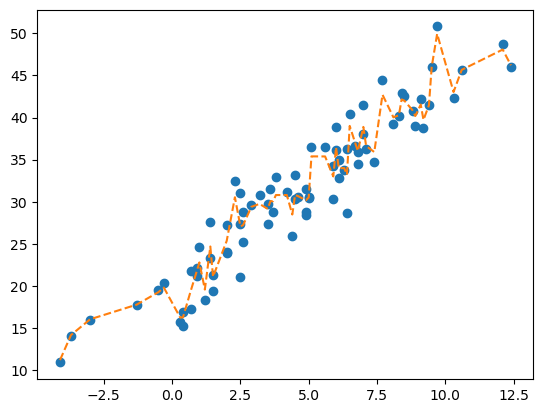

In [10]:
plt.plot(X,y,'o')
plt.plot(X,yhat,'--')

# 5. yhat을 얻는과정 – 어려움..

`-` `my_trees` 생성

In [49]:
trees = [t[0] for t in predictr.estimators_]
trees[0]

`-` 단순시도 (나무들의 평균으로) – 실패

In [132]:
_yhat = np.stack([tree.predict(X) for tree in trees]).mean(axis=0)
_yhat

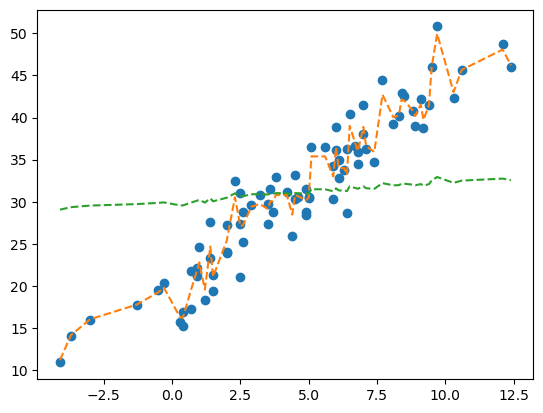

In [133]:
plt.plot(X,y,'o')
plt.plot(X,yhat,'--')
plt.plot(X,_yhat+y.mean(),'--')

`-` 처음 3개의 의사결정나무의 예측

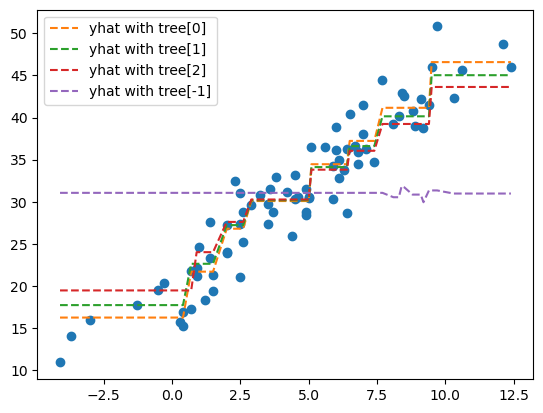

In [134]:
plt.plot(X,y,'o')
# plt.plot(X,yhat,'--')
plt.plot(X,trees[0].predict(X)+y.mean(),'--',label='yhat with tree[0]')
plt.plot(X,trees[1].predict(X)+y.mean(),'--',label='yhat with tree[1]')
plt.plot(X,trees[2].predict(X)+y.mean(),'--',label='yhat with tree[2]')
plt.plot(X,trees[-1].predict(X)+y.mean(),'--',label='yhat with tree[-1]')
plt.legend()

`-` 비밀이 뭘까?

-   초기값: `yhat` = `y.mean()`으로 적합 – ver 0.0
-   첫번째 나무를 반영하는 방법: 현재까지의 적합값 + 첫번째 나무의
    적합값 \* 0.1 – ver 0.01
-   두번째 나무를 반영하는 방법: 현재까지의 적합값 + 두번째 나무의
    적합값 \* 0.1 – ver 0.02
-   …
-   100번째 나무를 반영하는 방법: 현재까지의 적합값 + 100번째 나무의
    적합값 \* 0.1 – ver 1.00

`-` 시각화로 확인

In [135]:
(trees[0].predict(X)+trees[1].predict(X))

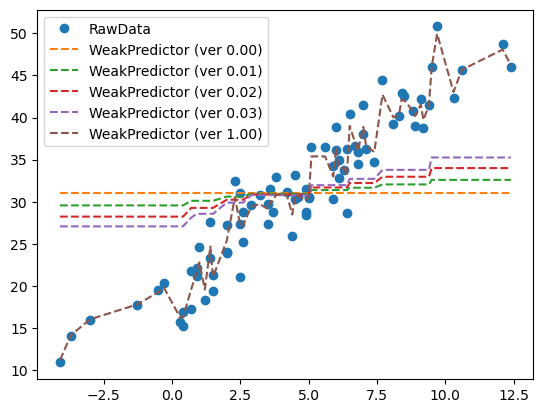

In [136]:
predictions = [tree.predict(X) for tree in trees]
plt.plot(X,y,'o',label='RawData')
plt.plot(X,y.mean()+y*0,'--',label='WeakPredictor (ver 0.00)')
plt.plot(
    X,
    y.mean() + np.stack(predictions[:1]).sum(axis=0)*0.1,
    '--',label='WeakPredictor (ver 0.01)'
)
plt.plot(
    X,
    y.mean() + np.stack(predictions[:2]).sum(axis=0)*0.1 ,
    '--',label='WeakPredictor (ver 0.02)'
)
plt.plot(
    X,
    y.mean() + np.stack(predictions[:3]).sum(axis=0)*0.1,
    '--',label='WeakPredictor (ver 0.03)'
)
plt.plot(
    X,
    y.mean() + np.stack(predictions[:]).sum(axis=0)*0.1,
    '--',label='WeakPredictor (ver 1.00)'
)
plt.legend()

`-` 애니메이션으로 표현

In [137]:
def ensemble(trees,i=None):
    if i is None:
        i = len(trees)
    else: 
        i = i+1
    yhat = np.stack([tree.predict(X) for tree in trees[:i]]).sum(axis=0)*0.1
    return yhat + y.mean()

In [157]:
fig = plt.figure()
ax = fig.subplots()
plt.close()
#---#
def func(i):
    ax.clear()
    ax.plot(X,y,'o',label='RawData')
    ax.plot(X,ensemble(trees,i),'--',label=f'WeakPredictor (ver {(i+1)/100:.2f})')
    ax.legend()
#---#    
ani = matplotlib.animation.FuncAnimation(
    fig,func,frames = 100
)
display(IPython.display.HTML(ani.to_jshtml()))

# 6. 재현

In [159]:
trees[0]

## A. 재현의 확인

`-` 아이디어:

-   처음부터 `yhat`을 강하게 학습하지 않고 약하게 조금씩 학습하자.
-   부족한 공부는 (=학습이 덜 되어있는 부분 =`y-yhat`)은 조금씩
    강화하면서 보완하자.

`-` 구현: `my_trees`, `my_residuals`를 직접구현

In [174]:
my_trees = [] 
my_residuals = [] 

In [175]:
res = y - y.mean()
# 첫공부 
for i in range(100):
    tree = sklearn.tree.DecisionTreeRegressor(
        criterion = 'friedman_mse',
        max_depth=3
    )
    tree.fit(X,res)
    yhat = tree.predict(X) 
    res = res - yhat * 0.1 # 학습한걸 다 반영하지 말고 0.1정도만 반영. 여기서 0.1은 학습율
    my_trees.append(tree)
    my_residuals.append(res)

`-` 비교: `my_trees`와 `trees`의 비교 (고정된 $i$)

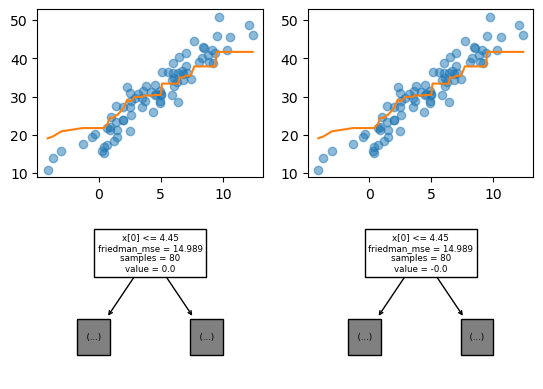

In [204]:
i=10
fig = plt.figure()
ax = fig.subplots(2,2)
ax[0,0].plot(X,y,'o',alpha=0.5)
ax[0,0].plot(X,ensemble(my_trees,i))
ax[0,1].plot(X,y,'o',alpha=0.5)
ax[0,1].plot(X,ensemble(trees,i))
sklearn.tree.plot_tree(my_trees[i],max_depth=0,ax=ax[1,0]);
sklearn.tree.plot_tree(trees[i],max_depth=0,ax=ax[1,1]);

`-` 비교: `my_trees`와 `trees`의 비교 (애니메이션)

In [207]:
#i=10
fig = plt.figure()
ax = fig.subplots(2,2)
plt.close()
#---#
def func(i):
    ax[0,0].clear()
    ax[0,0].plot(X,y,'o',alpha=0.5)
    ax[0,0].plot(X,ensemble(my_trees,i))
    #--#
    ax[0,1].clear()
    ax[0,1].plot(X,y,'o',alpha=0.5)
    ax[0,1].plot(X,ensemble(trees,i))
    #--#
    ax[1,0].clear()
    sklearn.tree.plot_tree(my_trees[i],max_depth=0,ax=ax[1,0]);
    #--#
    ax[1,1].clear()
    sklearn.tree.plot_tree(trees[i],max_depth=0,ax=ax[1,1]);
#---#
ani = matplotlib.animation.FuncAnimation(fig,func,frames=100)
display(IPython.display.HTML(ani.to_jshtml()))

## B. Step별 분석

In [213]:
fig,ax = plt.subplots(1,4,figsize=(10,3))
plt.close()

In [214]:
def func(i):
    ax[0].clear();
    ax[0].plot(X,y,'o',alpha=0.5)
    ax[0].plot(X,ensemble(my_trees,i),'--')
    ax[0].set_title("Step0")
    ax[1].clear();
    ax[1].set_ylim(-20,20)
    ax[1].plot(X,my_residuals[i],'o',alpha=0.5)
    ax[1].set_title("Step1:Residual")
    ax[2].clear();
    ax[2].set_ylim(-20,20)
    ax[2].plot(X,my_residuals[i],'o',alpha=0.5)
    ax[2].plot(X,my_trees[i].predict(X),'--')
    ax[2].set_title("Step2:Fit")
    ax[3].clear();
    ax[3].plot(X,y,'o',alpha=0.5)
    ax[3].plot(X,ensemble(my_trees,i),'--',color='C1')
    ax[3].plot(X,ensemble(my_trees,i+1),'--',color='C3')
    ax[3].set_title("Step3:Update")        

In [215]:
ani = matplotlib.animation.FuncAnimation(
    fig,
    func,
    frames = 50
)

In [216]:
display(IPython.display.HTML(ani.to_jshtml()))

-   관찰1: “Step1: Residual”은 점점 단순오차차럼 변화한다.
-   관찰2: “Step2: Fit”의 분기점들은 고정된 값이 아니다. (계속 변한다)
-   관찰3: “Step3: Update” 업데이터되는 양은 반복이 진행될수록 점점
    작아진다.

`-` 위의 그림에서

-   Step0: 공부할 자료, 현재까지 공부량
-   Step1: 남은 공부량
-   Step2: 공부! (이해O / 암기X)
-   Step3: 공부의 10%의 기억.. 기억나는 것만 두뇌에 update되어있음.

`-` 느낌: 조금씩 데이터를 학습한다. 학습할 자료가 오차항처럼 보인다면?
그때는 적합을 멈춘다. (오차항을 적합할 필요는 없잖아?)